In [2]:
import numpy as np
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
import re
import xlrd
import csv
import PyPDF2
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher
from spacy.tokens import Span
from string import punctuation

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

from nltk import tokenize
from nltk.tokenize import sent_tokenize
from nltk import word_tokenize, pos_tag

from collections import Counter
import math

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bristi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/bristi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/bristi/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Reading PDF and removing headers and other unnecessary info

In [23]:
import openai
import os
from dotenv import load_dotenv

load_dotenv()

api_key = os.getenv("API_KEY")
if not api_key:
    raise ValueError("API_KEY environment variable not set.")

openai.api_key = api_key

chosen_lines = []

def interpret_command_with_chatgpt(sentences):
    try:
        prompt_text = f"""I have extracted text from a PDF document which includes some sentences that seem incoherent or appear to be part of the header, page number, page title, or image descriptions. 
        This is a list of sentences {sentences} from the document. Please review each sentence and remove any that do not form a coherent part of the main text. 
        Return only the coherent and relevant sentences, as bullet points (-)
        """        
        # Call to the OpenAI API
        response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "user", "content": prompt_text}
            ]
        )

        cleaned_text = response['choices'][0]['message']['content'].strip()
        cleaned_sentences = []
        for line in cleaned_text.split('\n'):
            if line.startswith('- '):  # Check if the line is a main bullet point
                cleaned_sentences.append(line[2:].strip())
        return cleaned_sentences
    
    except Exception as e:
        print(f"An error occurred: {e}")
        return []

def clean_lines(i):
    clean_line = i.replace("\n", "")
    clean_line = clean_line.replace(" -", "")
    clean_line = clean_line.lstrip()
    
    return clean_line

def read_pdf_lines(pdf_path, page_number):
    with open(pdf_path, 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        page = reader.pages[page_number]
        text = page.extract_text()
        if text:
            lines = re.split('[.!?]', text)
            print(f"Page {page_number + 1}:")   
            
            lines = interpret_command_with_chatgpt(lines)

            i = 0
            for line in lines:
                i+=1
                new_line = clean_lines(line)
                chosen_lines.append(new_line)            
        
pdf_path = 'a-better-world-vol-5_sdo.pdf'

for page_number in range(0,1):
    read_pdf_lines(pdf_path, page_number)

print(chosen_lines)

Page 1:
['Dubai is one of the seven Emirates that constitute the United Arab Emirates (UAE) in the Gulf region with a population of over 3 million people.', 'Dubai is a regional, vibrant economic hub with strategically competitive sectors such as tourism, trade and logistics, real estate, retail, financial services, healthcare and education.', 'Dubai’s economy has grown 11-fold between 1975 and 2008 rendering it the fastest-growing economy in the world over the same period.', 'During the past two decades, numerous strategic ICT and digital transformation initiatives in the city have altered and digitised various aspects of life.', 'Dubai incorporates ‘smart design’ into its fabric and has been able to fuse cyber and physical infrastructure and systems while rapidly expanding to accommodate the next projected 30 million visitors by 2020.', 'Dubai has already achieved world-class leading city status with respect to various SDG 11 indicators.', 'Housing: No one lives in slums, and there a

# PDF to CSV

In [59]:
filename = "sentences.csv"

with open(filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Sentence'])
    for sentence in chosen_lines:
        writer.writerow([sentence])

print(f"Sentences have been written to {filename}")

Sentences have been written to sentences.csv


# Pronoun replacement

In [24]:
def getTagsForWords(text):
    tokens=word_tokenize(text)
    tagged=pos_tag(tokens)
    return(tagged)

def getNounPositions(tagged,text):      #def getNounPositions(type,tagged,text):
    nounPosi={}
    for item in tagged:
        if (item[1]=='NN' or item[1]=='NNS'):       #if item[1]==type:
            nounPosi[item[0]]=-1

    for key in nounPosi.keys():
        regExpression=r'\b'+key.lower()+r'\b'
        nounsi=[m.start() for m in re.finditer(regExpression, text.lower())]
        nounPosi[key]=nounsi
    return nounPosi

def getProNounPositions(tagged,text):
    proNounPosi={}
    for item in tagged:
        if item[1]=='PRP': #or item[1]=='PRP$':
            proNounPosi[item[0].lower()]=-1

    for key in proNounPosi.keys():
        regExpression=r'\b'+key.lower()+r'\b'
        pronounsi=[m.start() for m in re.finditer(regExpression, text.lower())]
        proNounPosi[key]=pronounsi
    return proNounPosi

def getNearestPreviousNoun(NNP,posiOfPronoun, text, *args):
    minimumDiff=len(text)
    nearKey=''
    for keyNNP in NNP.keys():
        for posNoun in NNP[keyNNP]:
            if(posiOfPronoun>posNoun):
                if(minimumDiff>(posiOfPronoun-posNoun)):
                    minimumDiff=posiOfPronoun-posNoun
                    nearKey=keyNNP
    if nearKey=='':
        if (args[0]):
            previoustagged = getTagsForWords(args[0])
            previousNNP = getNounPositions(previoustagged, args[0])
            keyspreviousNNP = list(previousNNP.keys())
            if (args[1].lower() in keyspreviousNNP):
                nearKey = args[1]
            else:
                nearKey = keyspreviousNNP[0]
    return nearKey

def pronounReplaceWithNearNoun(text, PRP, NNP, *args):
    replacePRP = []
    for key in PRP.keys():
        for pos in PRP[key]:
            if args and len(args) >= 2:  # Check if args is not empty and has at least two elements
                nearNoun = getNearestPreviousNoun(NNP, pos, text, args[0], args[1])
            else:
                nearNoun = getNearestPreviousNoun(NNP, pos, text)
            replacePRP.append((key, pos, nearNoun))

    replacePRP = sorted(replacePRP, key=lambda x: (-x[1], x[0], x[2]))
    lineInReplacePronn = text
    for prpRep in replacePRP:
        lineInReplacePronn = lineInReplacePronn[:prpRep[1]] + prpRep[2] + lineInReplacePronn[prpRep[1] + len(prpRep[0]):]
    return lineInReplacePronn


In [25]:
full_text = " ".join(chosen_lines)

tagged_tokens = getTagsForWords(full_text)
noun_positions = getNounPositions(tagged_tokens, full_text)
pronoun_positions = getProNounPositions(tagged_tokens, full_text)
replaced_text = pronounReplaceWithNearNoun(full_text, pronoun_positions, noun_positions)

candidate_sentences = replaced_text.split('.')
# Remove any leading or trailing whitespace and filter out any empty strings
candidate_sentences = [candidate_sentences.strip() for candidate_sentences in candidate_sentences if candidate_sentences.strip()]

In [26]:
candidate_sentences

['Dubai is one of the seven Emirates that constitute the United Arab Emirates (UAE) in the Gulf region with a population of over 3 million people',
 'Dubai is a regional, vibrant economic hub with strategically competitive sectors such as tourism, trade and logistics, real estate, retail, financial services, healthcare and education',
 'Dubai’s economy has grown 11-fold between 1975 and 2008 rendering economy the fastest-growing economy in the world over the same period',
 'During the past two decades, numerous strategic ICT and digital transformation initiatives in the city have altered and digitised various aspects of life',
 'Dubai incorporates ‘smart design’ into its fabric and has been able to fuse cyber and physical infrastructure and systems while rapidly expanding to accommodate the next projected 30 million visitors by 2020',
 'Dubai has already achieved world-class leading city status with respect to various SDG 11 indicators',
 'Housing: No one lives in slums, and there are 

# Testing Extraction of Attributes using spaCy

1. amod (adjectival modifier): This label is used to connect an adjective to the noun it modifies. The adjective serves as a modifier that directly describes or qualifies a noun, providing more information about the noun's attributes. For example, in the phrase "green park," "green" is an adjectival modifier of "park" and would be tagged as amod.

2. compound (compound noun): This label is used to link together two or more words that together constitute a single noun phrase, typically combining nouns or a combination of adjectives and nouns. This compound structure often forms a new meaning that describes a specific concept or thing. For instance, in "rainwater harvesting," "rainwater" is a compound that modifies "harvesting," indicating a specific type of harvesting.

3. adj (adjective)

4. adv (adverb)

In [7]:
chosen_lines = ['Dubai has good weather.', 'Dubai has bad weather.']

In [9]:
def extract_adjectives_adverbs(text):
    doc = nlp(text)
    adjectives = []
    adverbs = []
    numbers = []
    for token in doc:
        if token.pos_ == 'ADJ':
            adjectives.append(token.text)
        elif token.pos_ == 'ADV':
            adverbs.append(token.text)
        elif token.pos_ == 'NUM':
            numbers.append(token.text)
    return adjectives, adverbs, numbers


def extract_attributes(text):
    doc = nlp(text)
    attributes = []
    for ent in doc.ents:
        ent_attributes = []
        for token in ent.subtree:
            if token.dep_ in ['amod', 'compound']:  # Looking for adjectives and compounds
                ent_attributes.append(token.text)
        if ent_attributes:
            attributes.append((ent.text, ent_attributes))
    return attributes

In [10]:
import pandas as pd

# candidate_sentences = pd.read_csv("sentences.csv")

# for i in range(len(candidate_sentences)):
#     test = candidate_sentences['Sentence'][i]
#     attributes = extract_attributes(test)
#     adjectives, adverbs, numbers = extract_adjectives_adverbs(test)
#     print("Sentence:", test)
#     print("Adjectives:", adjectives)
#     print("Adverbs:", adverbs)
#     print("Num:", numbers)
#     print('\n')
    
candidate_sentences = chosen_lines
   
for i in range(len(candidate_sentences)):
    test = candidate_sentences[i]
    attributes = extract_attributes(test)
    adjectives, adverbs, numbers = extract_adjectives_adverbs(test)
    print("Sentence:", test)
    print("Adjectives:", adjectives)
    print("Adverbs:", adverbs)
    print("Num:", numbers)
    print('\n')


Sentence: Dubai has good weather.
Adjectives: ['good']
Adverbs: []
Num: []


Sentence: Dubai has bad weather.
Adjectives: ['bad']
Adverbs: []
Num: []




# Extract attributes using ChatGPT

In [52]:
import openai
import os
from dotenv import load_dotenv

load_dotenv()

api_key = os.getenv("API_KEY")
if not api_key:
    raise ValueError("API_KEY environment variable not set.")

openai.api_key = api_key

def interpret_command_with_chatgpt(command):
    try:
        prompt_text = f"""Please extract adjectives, adverbs from this sentence: {command}.
        Output as seperate lists in this manner. The elements in the list are seperated by commas. Adjectives: \nAdverbs:
        """
        
        prompt2 = f"""
            Please analyze the sentence provided in the {command} variable and extract all adjectives and adverbs. List the adjectives and adverbs separately, with each element in the list separated by commas. Adjectives should be listed under "Adjectives" and adverbs under "Adverbs."
        """

        response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "user", "content": prompt2}
            ]
        )

        return response['choices'][0]['message']['content'].strip()
    except Exception as e:
        print(f"An error occurred: {e}")
        return "Error processing command"

sample_command = "I am an awesome person"
print(sample_command)
print(interpret_command_with_chatgpt(sample_command))

I am an awesome person
Sentence: "I am an awesome person"

Adjectives: awesome

Adverbs: None


In [44]:
import openai
import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Get API key from environment variables
api_key = os.getenv("API_KEY")
if not api_key:
    raise ValueError("API_KEY environment variable not set.")

# Set the API key for the OpenAI library
openai.api_key = api_key

def interpret_with_chatgpt_output_as_lists(command):
    try:
        prompt_text = f"""Please extract adjectives, adverbs from this sentence: {command}.
        Output as seperate lists in this manner. The elements in the list are seperated by commas
        Adjectives: 
        Adverbs:
        """

        response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "user", "content": prompt_text}
            ]
        )

        response_text = response['choices'][0]['message']['content'].strip()
        lines = response_text.split('\n')
        adjectives = []
        adverbs = []

        for line in lines:
            if line.startswith("Adjectives:"):
                adj_line = line.replace("Adjectives:", "").strip()
                if adj_line:
                    adjectives = [adj.strip() for adj in adj_line.split(',')]
            elif line.startswith("Adverbs:"):
                adv_line = line.replace("Adverbs:", "").strip()
                if adv_line:  
                    adverbs = [adv.strip() for adv in adv_line.split(',')]

        return adjectives, adverbs

    except Exception as e:
        print(f"An error occurred: {e}")
        return [], []

# Sample usage
sample_command = "I am an awesome person"
print(sample_command)
adjectives, adverbs = interpret_with_chatgpt_output_as_lists(sample_command)
print("Adjectives:", adjectives)
print("Adverbs:", adverbs)


I am an awesome person
Adjectives: ['awesome']
Adverbs: []


In [55]:
candidate_sentences = pd.read_csv("sustainable_cities_sentences.csv")

for i in range(len(candidate_sentences)):
    test = candidate_sentences['Sentence'][i]
    print(test)
    response = interpret_command_with_chatgpt(test)
    print(response)
    print('\n')


Sustainable cities actively prioritize environmental, social, and economic sustainability in their development and operations.
Adjectives: Sustainable, environmental, social, economic  
Adverbs: Actively


Urban planning in sustainable cities rigorously focuses on reducing carbon footprints, enhancing lush green spaces, and promoting rich biodiversity.
Adjectives: sustainable, lush, green, rich
Adverbs: rigorously, reducing, enhancing, promoting


Renewable energy sources, such as solar and wind power, are crucially integral to the energy strategy of sustainable cities.
Adjectives: renewable, sustainable
Adverbs: crucially, integral


Public transportation systems in sustainable cities are strategically designed to be efficient, widely accessible, and significantly reduce reliance on private vehicles.
Adjectives: sustainable, efficient, widely accessible, private
Adverbs: strategically, significantly


Waste management in sustainable cities involves innovative recycling, composting, an

# Processing the ER

This code identifies entities with modifier

In [29]:
def get_entities(sent):
    nlp = spacy.load("en_core_web_sm")
    ent1 = ""
    ent2 = ""

    prv_tok_dep = ""    # Dependency tag of the previous token in the sentence
    prv_tok_text = ""   # Previous token in the sentence

    prefix = ""
    modifier = ""

    adjectives = []  
    adverbs = []
    numbers = []  

    for tok in nlp(sent):
        if tok.dep_ != "punct":
            # Handling compound nouns
            if tok.dep_ == "compound":
                prefix = tok.text if not prefix else prefix + " " + tok.text

            if tok.dep_.endswith("mod"):  # Includes 'amod' (adjectival modifier)
                modifier = tok.text if not modifier else modifier + " " + tok.text

            if tok.pos_ == "ADV":
                adverbs.append(tok.text)
                
            if tok.pos_ == 'NUM':
                numbers.append(tok.text)

            if "subj" in tok.dep_:
                ent1 = f"{modifier} {prefix} {tok.text}".strip()
                adjectives.append(modifier)
                prefix, modifier = "", ""

            if "obj" in tok.dep_:
                ent2 = f"{modifier} {prefix} {tok.text}".strip()
                prefix, modifier = "", ""

        # Update the previous token variables
        prv_tok_dep, prv_tok_text = tok.dep_, tok.text

    return {
        'Entity1': ent1,
        'Entity2': ent2,
        'Adjectives': adjectives,
        'Adverbs': adverbs,
        'Numbers': numbers
    }
# previous code"

This code identifies entities without the modifier

In [33]:
def get_entities(sent):
    nlp = spacy.load("en_core_web_sm")
    ent1 = ""
    ent2 = ""

    prv_tok_dep = ""    # Dependency tag of the previous token in the sentence
    prv_tok_text = ""   # Previous token in the sentence

    prefix = ""
    modifier = ""

    adjectives = []  
    adverbs = []
    numbers = []  

    for tok in nlp(sent):
        if tok.dep_ != "punct":
            # Handling compound nouns
            if tok.dep_ == "compound":
                prefix = tok.text if not prefix else prefix + " " + tok.text
                
            if tok.pos_ == 'ADJ':
                if tok.text != '':
                    adjectives.append(tok.text)

            if tok.dep_.endswith("ADJ"):  # Includes 'amod' (adjectival modifier)
                modifier = tok.text if not modifier else modifier + " " + tok.text

            if tok.pos_ == "ADV":
                adverbs.append(tok.text)
                
            if tok.pos_ == 'NUM':
                numbers.append(tok.text)

            if "subj" in tok.dep_:
                ent1 = f"{tok.text}".strip()
                prefix, modifier = "", ""

            if "obj" in tok.dep_:
                ent2 = f"{modifier} {prefix} {tok.text}".strip()
                prefix, modifier = "", ""

        # Update the previous token variables
        prv_tok_dep, prv_tok_text = tok.dep_, tok.text

    return {
        'Entity1': ent1,
        'Entity2': ent2,
        'Adjectives': adjectives,
        'Adverbs': adverbs,
        'Numbers': numbers
    }

In [34]:
entity_pairs = []
# candidate_sentences = chosen_lines

for i in tqdm(candidate_sentences):
  entity_pairs.append(get_entities(i))

100%|██████████| 35/35 [00:10<00:00,  3.34it/s]


In [32]:
entity_pairs

In [35]:
def get_relation(sent):
    doc = nlp(sent)

    matcher = Matcher(nlp.vocab)

    pattern = [
        {'DEP': 'ROOT'},  
        {'DEP': 'prep', 'OP': "?"},
        {'DEP': 'agent', 'OP': "?"}, 
        {'POS': 'ADJ', 'OP': "?"}, 
        {'POS': 'ADV', 'OP': "*"},  
        {'DEP': 'amod', 'OP': "?"}, 
        {'DEP': 'acl', 'OP': "?"},  
        {'DEP': 'attr', 'OP': "?"}
    ]

    matcher.add("matching_1", [pattern])

    matches = matcher(doc)
    
    if matches:
        k = len(matches) - 1
        span = doc[matches[k][1]:matches[k][2]]
        return span.text
    else:
        return "No relation found"

In [36]:
relations = [get_relation(i) for i in tqdm(candidate_sentences)]

100%|██████████| 35/35 [00:00<00:00, 106.17it/s]


In [16]:
relations

['has good', 'has bad']

In [37]:
def process_entity_relations(entity_pairs_with_attrs, relations):
    # Clean up empty entities and the corresponding relations
    cleaned_pairs = []
    cleaned_relations = []
    for pair, rel in zip(entity_pairs_with_attrs, relations):
        if pair['Entity1'] and pair['Entity2']:  # Ensure no empty entities
            cleaned_pairs.append(pair)
            cleaned_relations.append(rel)

    # Prepare data for the knowledge graph
    er_info = []
    for pair, rel in zip(cleaned_pairs, cleaned_relations):
        er_dict = {
            "entity1": pair['Entity1'],
            "entity2": pair['Entity2'],
            "relation": rel,
            "adjectives_entity1": pair['Adjectives'],
            "adverbs": pair['Adverbs'],  # Assuming adverbs relate to the action/link
            "numbers": pair['Numbers']
        }

        # Use NLTK to determine the grammatical number of entities
        first_ent = nltk.pos_tag([pair['Entity1'].split()[-1]])  # Get last word of entity1 for tagging
        second_ent = nltk.pos_tag([pair['Entity2'].split()[-1]])  # Get last word of entity2 for tagging

        # Classifying the relation type based on the grammatical number
        if first_ent[0][1].startswith("NN") and second_ent[0][1].startswith("NN"):
            er_dict["relation type"] = "one-one"
        elif first_ent[0][1].startswith("NN") and second_ent[0][1].startswith("NNS"):
            er_dict["relation type"] = "one-many"
        elif first_ent[0][1].startswith("NNS") and second_ent[0][1].startswith("NN"):
            er_dict["relation type"] = "many-one"
        elif first_ent[0][1].startswith("NNS") and second_ent[0][1].startswith("NNS"):
            er_dict["relation type"] = "many-many"
        else:
            er_dict["relation type"] = "undefined"

        er_info.append(er_dict)

    return er_info

In [38]:
er_info = process_entity_relations(entity_pairs, relations)

The dictionary er_info created is being stored in a text file format.

In [44]:
dictfile = open('dubai_with_attr_no_modifier_in_entity.txt', 'w')
dictfile.write("SNO, Entity1, Entity2, Relation, Relation Type\n")
for i in range(len(er_info)):
    dictfile.write(str(i+1) + ", " + er_info[i]["entity1"] + ", " + er_info[i]["entity2"] + ", " + er_info[i]["relation"] + ", " + er_info[i]["relation type"] + "\n")
dictfile.close()

In [45]:
ep = entity_pairs.copy()

In [46]:
# Extract 'Entity1' as source and 'Entity2' as target
source = [item['Entity1'] for item in ep if item['Entity1'] and item['Entity2']]
target = [item['Entity2'] for item in ep if item['Entity1'] and item['Entity2']]
filtered_relations = [relations[i] for i in range(len(ep)) if ep[i]['Entity1'] and ep[i]['Entity2']]
adjectives = [item.get('Adjectives', []) for item in ep if item['Entity1'] and item['Entity2']]
adverbs = [item.get('Adverbs', []) for item in ep if item['Entity1'] and item['Entity2']]
numbers = [item.get('Numbers', []) for item in ep if item['Entity1'] and item['Entity2']]

# Create the DataFrame
kg_df= pd.DataFrame({
    'source': source,
    'target': target,
    'edge': filtered_relations,
    'adjectives': adjectives,
    'adverbs': adverbs,
    'numbers': numbers,
})

In [120]:
kg_df

,source,target,edge,adjectives,adverbs,numbers
0,that,over million 3 people,is one,"[, ]",[],"[one, seven, 3, million]"
1,Dubai,such tourism,is,[],[strategically],[]
2,economy,same period,grown,[],[fastest],"[11, 1975, 2008]"
3,Dubai,various SDG 11 indicators,achieved,[],[already],[11]
4,100 per cent potable water supply,sanitation facilities,includes,"[, 100 per cent potable]",[],[100]
5,Dubai,world,has,[],[],[one]
6,Long term strategies,smart autonomous mobility strategies,include,[Long],[],[11]
7,Smart Dubai,city experiences,aims,[],[],[]
8,Smart Dubai initiative,IoT,encompasses various,[],[],[]
9,Dubai 2021 Smart strategy,inclusive ecosystem,includes,[Dubai 2021],[strategically],[2021]


# Knowledge Graph Generation

#### Graph if no modifiers in entities

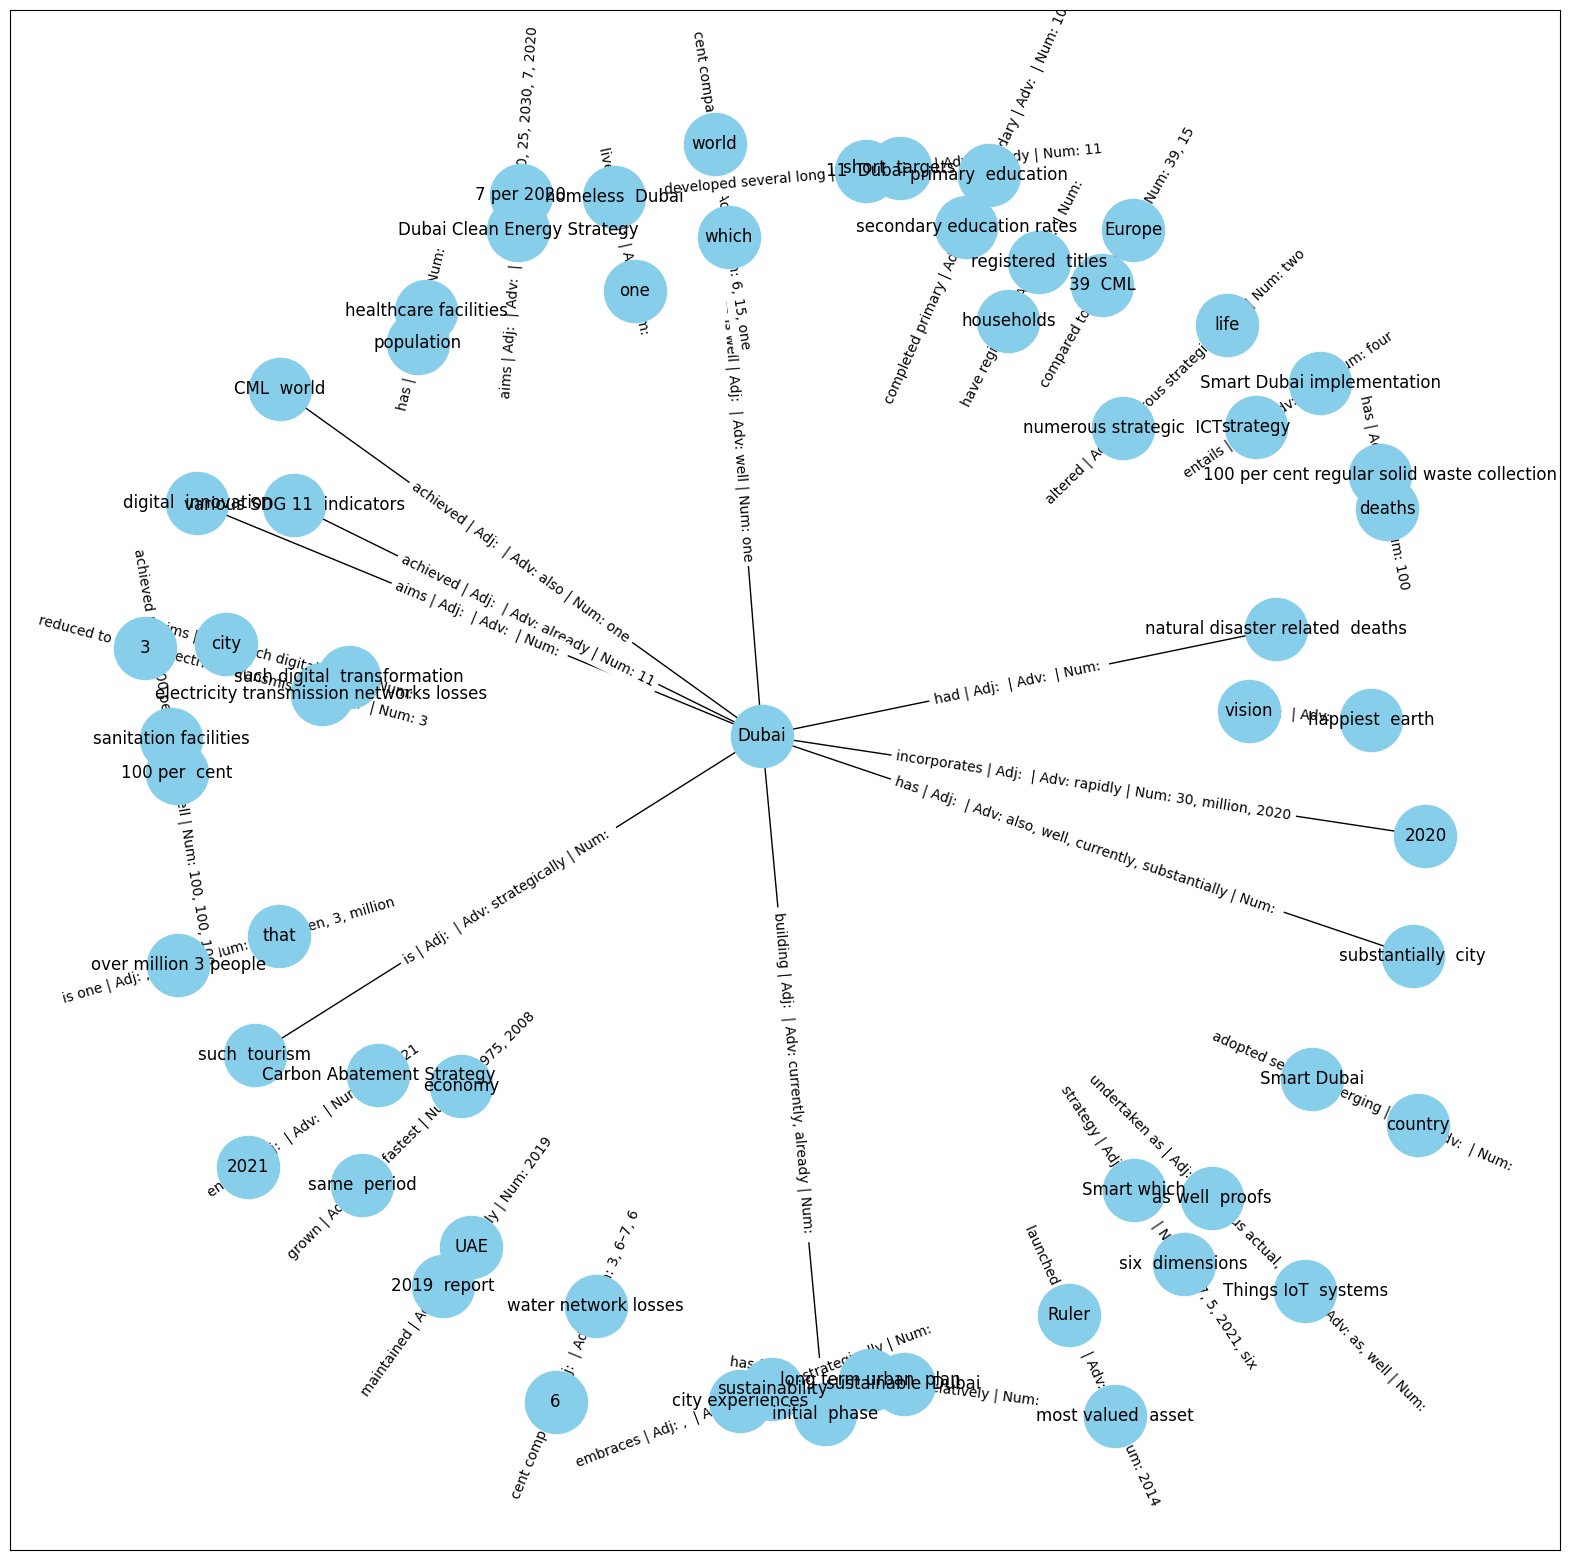

In [49]:
G = nx.from_pandas_edgelist(kg_df2, "source", "target",
                            edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(20,20))

pos = nx.spring_layout(G)  

nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=2000)
nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=10)
nx.draw_networkx_labels(G, pos)

edge_labels = {(u, v): f"{d['edge']} | Adj: {', '.join(d['adjectives'])} | Adv: {', '.join(d['adverbs'])} | Num: {', '.join(d['numbers'])}"
               for u, v, d in G.edges(data=True)}

nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.show()

#### Graph if modifiers allowed in entities

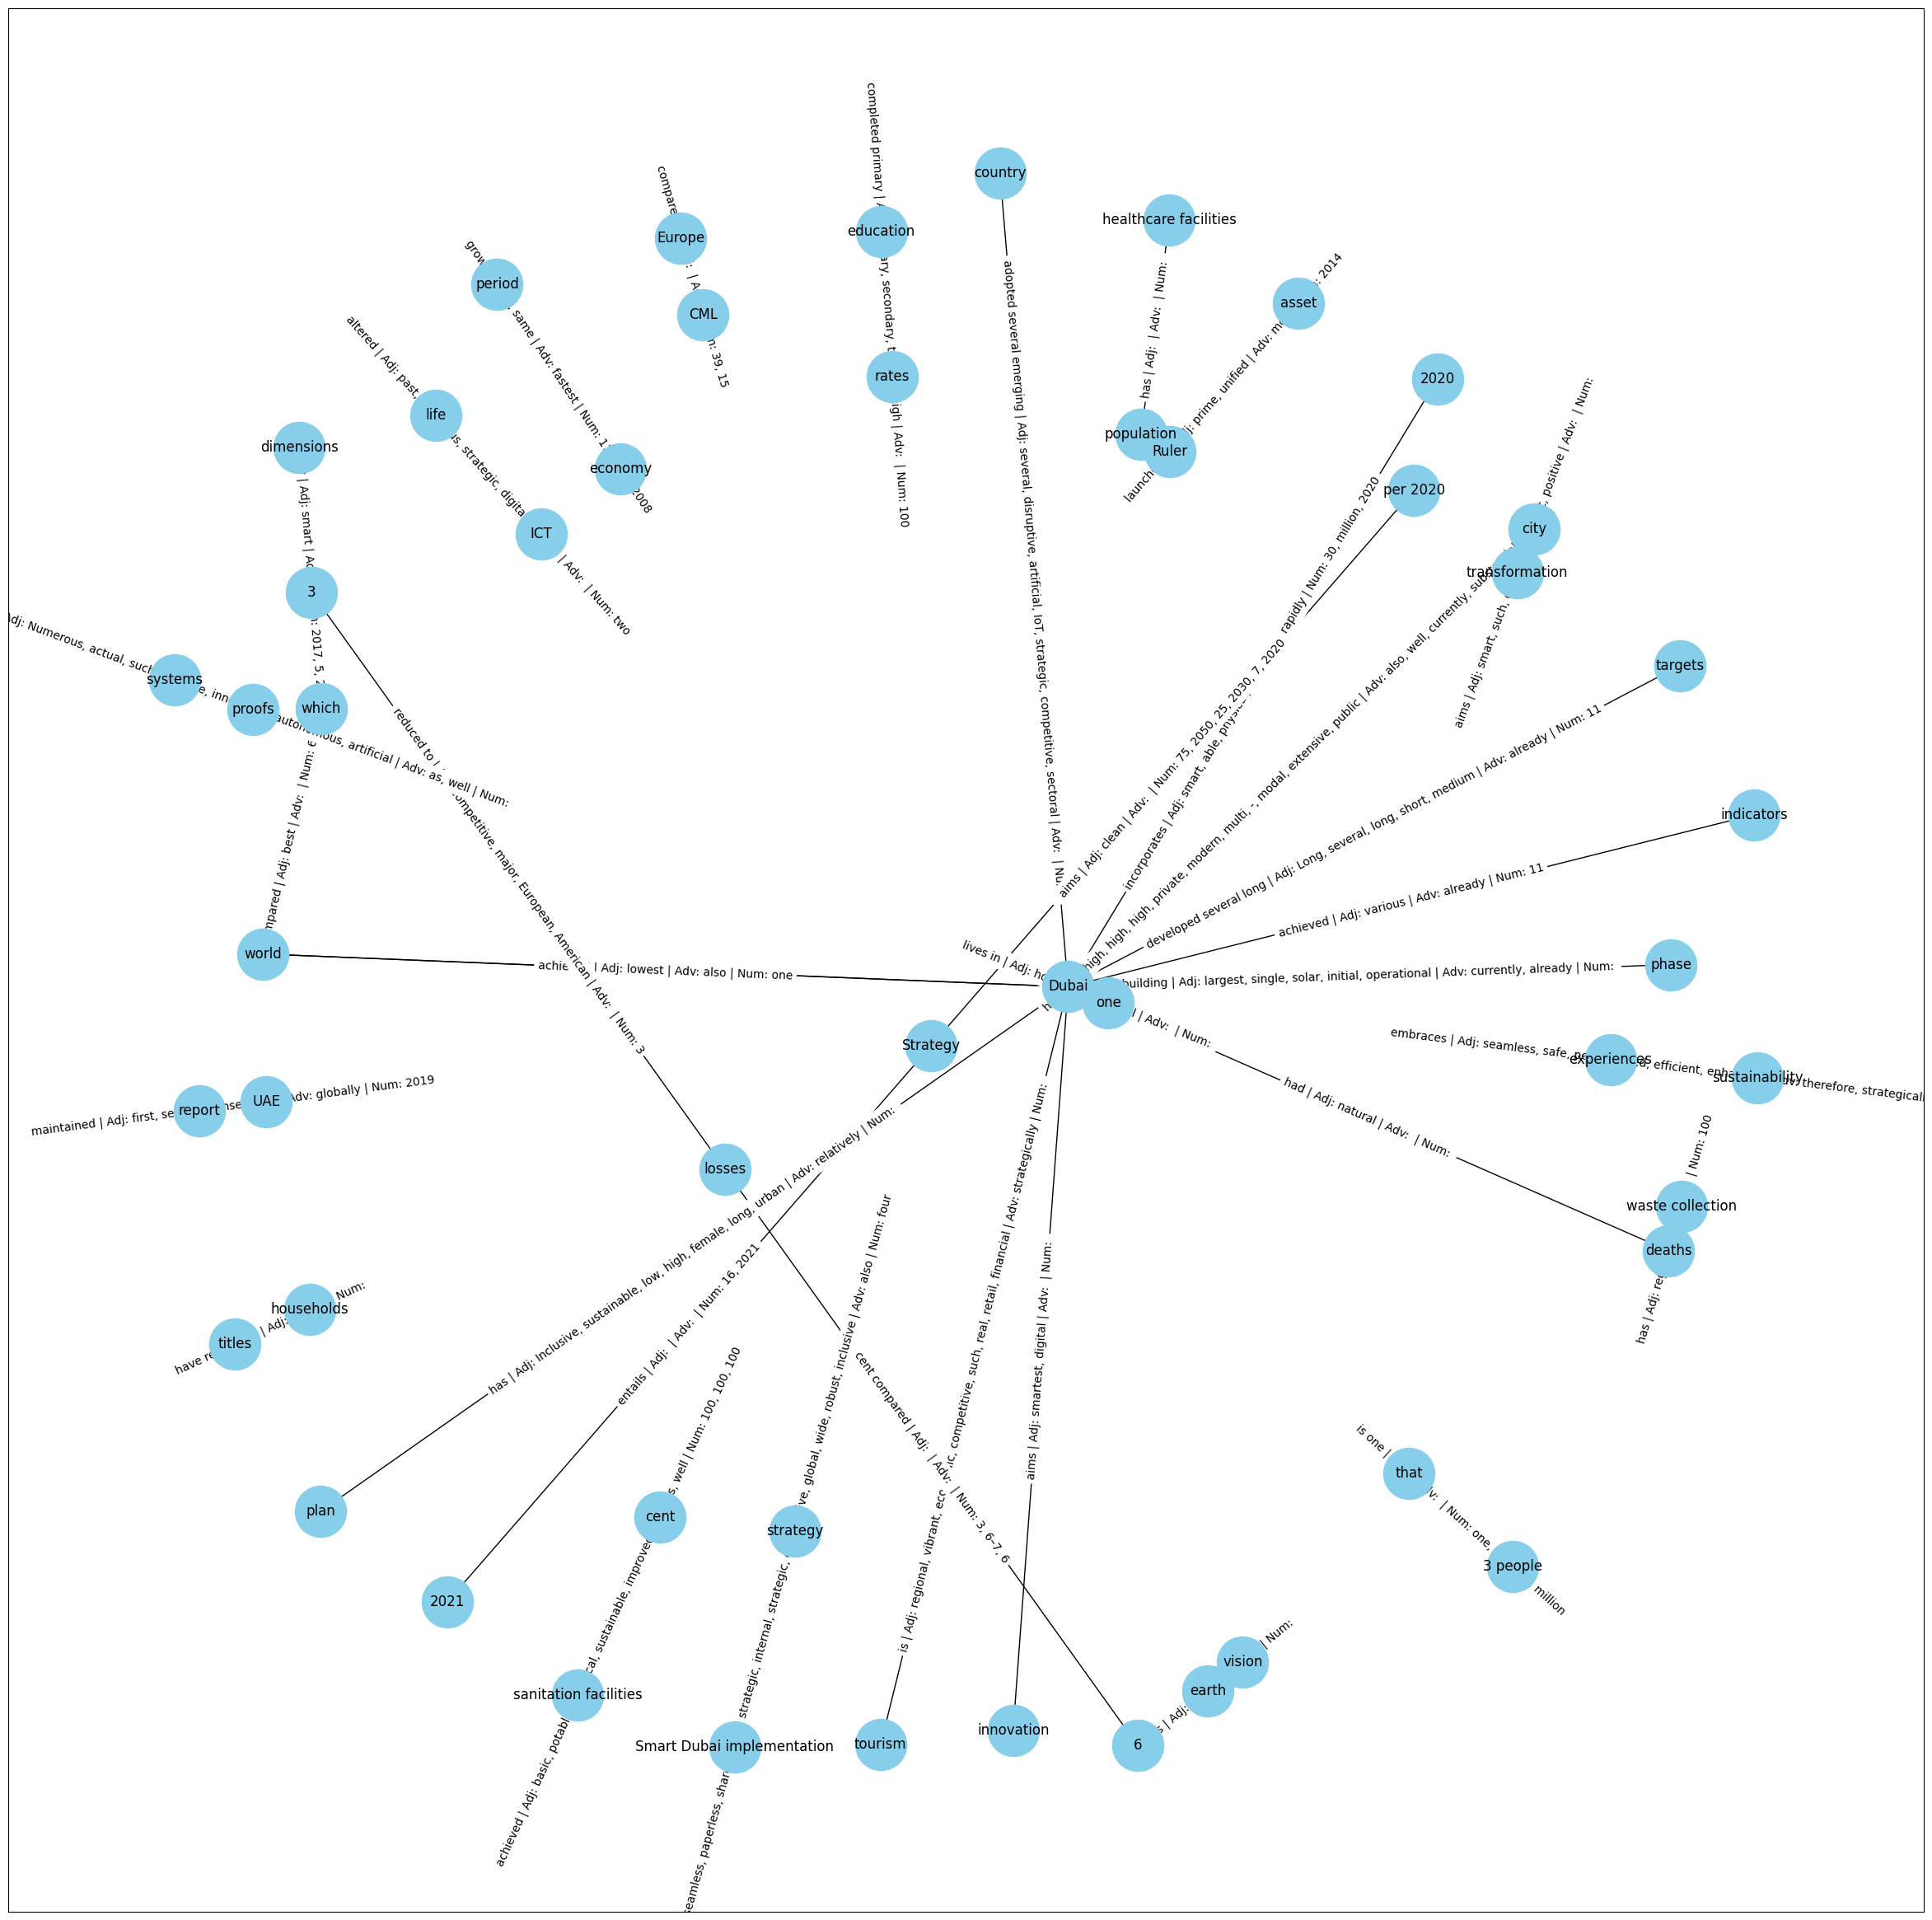

In [42]:
G = nx.from_pandas_edgelist(kg_df, "source", "target",
                            edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(30,30))

pos = nx.spring_layout(G)  

nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=2000)
nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=10)
nx.draw_networkx_labels(G, pos)

edge_labels = {(u, v): f"{d['edge']} | Adj: {', '.join(d['adjectives'])} | Adv: {', '.join(d['adverbs'])} | Num: {', '.join(d['numbers'])}"
               for u, v, d in G.edges(data=True)}

nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.show()

# Generating Isabelle-Hol 

In [123]:
# Initialize file writing
file = open('sustainable_cities_with_attr_new.thy', 'w')
file.write("theory sustainable_cities_with_attr_new imports Main\n")
file.write("begin \n\n")
file.write("typedecl i\n")
file.write("type_synonym entity = \"i \<Rightarrow> bool\"\n")
file.write("type_synonym relation = \"i \<Rightarrow> i \<Rightarrow> bool\"\n\n")

# General definitions
file.write("definition disjoint :: \"entity \<Rightarrow> entity \<Rightarrow> bool\" where \n    \"disjoint C1 C2 \<equiv> \<not>(\<exists>x::i. C1 x \<and> C2 x)\"\n")
file.write("definition conv_rel :: \"relation \<Rightarrow> relation\" where \n   \"conv_rel Rel \<equiv> (\<lambda>x y. Rel y x)\"\n")
file.write("definition is_empty_rel :: \"relation \<Rightarrow> bool\" where \n   \"is_empty_rel Rel \<equiv> \<forall>x y. \<not>Rel x y\"\n")

# Entity declarations
file.write("\nconsts\n  (*Entities*)\n")
entities = set(item['entity1'].replace(" ", "_") for item in er_info) | set(item['entity2'].replace(" ", "_") for item in er_info)
for entity in entities:
    file.write(f"  {entity} :: entity\n")

# Relation declarations
file.write("\n  (*Relations*)\n")
relations = set(item['relation'].replace(" ", "_") for item in er_info)
for relation in relations:
    file.write(f"  {relation.capitalize()} :: relation\n")

# Axiomatizations
for index, item in enumerate(er_info):
    relation_name = item['relation'].replace(" ", "_").capitalize()
    e1 = item['entity1'].replace(" ", "_")
    e2 = item['entity2'].replace(" ", "_")
    rel_type = item['relation type'].replace("-", "_")
    if rel_type == "one_one":
        file.write(f"\naxiomatization where \none_to_many_{index}: \"one_to_n_rel {e1} {e2} {relation_name}\"\n")
    elif rel_type == "many_one":
        file.write(f"\naxiomatization where \nmany_to_one_{index}: \"n_to_one_rel {e2} {e1} {relation_name}\"\n")
    elif rel_type == "many_many":
        file.write(f"\naxiomatization where \nmany_to_many_{index}: \"n_to_m_rel {e1} {e2} {relation_name}\"\n")

file.write("\n\n(*Consistency Check*) \n")
file.write("lemma True nitpick[satisfy, user_axioms, show_all, format=3] oops (* Model found *)\n\n")
file.write("end\n")
file.close()